TODO Find a MS frag tree where
- Charge is more varied (not just 0 or +1)
- There are ideally 3 branches and a depth of about 3

Mass spectrometric analysis is helpful for biomolecules. Tools such as the [SIRIUS software framework](https://bio.informatik.uni-jena.de/software/sirius/) have been developed to analyze fragmentation trees.

In [701]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors

In [702]:
# Utilities
def flatten_twoD_list(twoD_list: list[list]) -> list:
    flat_list = []
    for row in twoD_list:
        for item in row:
            flat_list += [item]
    return flat_list

def longest_row(twoD_list: list[list]) -> int:
    return max(len(row) for row in twoD_list)

def get_fraction(num, denom):
    if denom:
        return num / denom
    else:
        return 0
        # return None

In [703]:

def concat_grids_horizontally(grid1:list[list[str]], grid2:list[list[str]]) -> list[list[str]]:
    """Concatenate two nested lists horizontally, for example
    inputs [['a'],['b'],['c']] and [['d'], ['e'], ['f']] 
    produce [['a', 'd'], ['b', 'e'], ['c', 'f']]

    :returns: The combined grid, a two-deep nested list of strings
    :param grid1: The first grid, a two-deep nested list of strings
    :param grid2: The second grid, a two-deep nested list of strings
    """
    if grid1 == [[]]:
        combined = grid2
    elif grid2 == [[]]:
        combined = grid1
    else:
        combined = []
        for row_counter in range(len(grid1)):
            combined += [grid1[row_counter] + grid2[row_counter]]
    return combined

class NonBinTree:
    """
    Nonbinary tree class
    Note that this class is not designed to sort nodes as they are added to the tree;
    the assumption is that they should be ordered in the order added
    Adapted from https://stackoverflow.com/questions/60579330/non-binary-tree-data-structure-in-python#60579464
    """

    def __init__(self, val:str, label=None):
        """Create a NonBinTree instance"""
        self.val = val
        self.label = label
        self.nodes = []

    def add_node(self, val:str, label=None):
        """Add a node to the tree and return the new node"""
        self.nodes.append(NonBinTree(val, label))
        return self.nodes[-1]

    def __repr__(self) -> str:
        """Print out the tree as a nested list"""
        return f"NonBinTree({self.val}): {self.nodes}"

    def get_ncols(self) -> int:
        """Get the number of columns in the tree"""
        self.ncols = 0
        if len(self.nodes) > 0:
            # If there are nodes under this one, call get_ncols on them recursively
            for node in self.nodes:
                self.ncols += node.get_ncols()
        else:
            # If there are no nodes under this one, add 1 for this node
            self.ncols += 1
        return self.ncols

    def get_max_depth(self) -> int:
        """Get the maximum depth of the tree"""
        max_depth = 0
        if len(self.nodes) > 0:
            for node in self.nodes:
                this_depth = node.get_max_depth()
                max_depth = max(this_depth + 1, max_depth)
        else:
            max_depth = max(1, max_depth)
        self.max_depth = max_depth
        return self.max_depth

    def get_grid(self) -> list[list[str]]:
        """
        Get a two-dimensional grid where
        each row is a level in the fragment hierarchy, and
        the columns serve to arrange the fragments horizontally
        """
        # Call methods to calculate self.ncols and self.max_depth
        self.get_ncols()
        self.get_max_depth()

        # Create top row: Node value, then the rest of columns are blank (empty strings)
        grid = [[self.val] + [""] * (self.ncols - 1)]
        grid_label = [[self.label] + [""] * (self.ncols - 1)]

        n_nodes = len(self.nodes)

        if n_nodes > 0:
            nodes_grid = [[]]
            nodes_grid_label = [[]]

            # Iterate through the chile nodes
            for node_counter, node in enumerate(self.nodes):
                # Recursively call this function to get the grid for children
                node_grid, node_grid_label = node.get_grid()

                # Add spacer rows if needed
                node_grid_rows = len(node_grid)
                rows_padding = self.max_depth - node_grid_rows - 1
                for padding in range(rows_padding):
                    padding_to_add = [[""] * len(node_grid[0])]
                    node_grid += padding_to_add
                    node_grid_label += padding_to_add

                nodes_grid = concat_grids_horizontally(nodes_grid, node_grid)
                nodes_grid_label = concat_grids_horizontally(nodes_grid_label, node_grid_label)

            grid += nodes_grid
            grid_label += nodes_grid_label

        return grid, grid_label

In [704]:
def mass_spec_frag_tree(non_bin_tree, ndigits:int or None = 2, addHs:bool=False, verbose:bool=False, **kwargs):
    """
    Draw a mass spectrometry fragmentation tree

    :returns: RDKit grid image, and (if verbose=True) fragment tree as 2D (nested) list
    :rtype: RDKit grid image, and (if verbose=True) molecules as list[list[mol]], labels as list[list[str]], mass (Daltons) as list[list[float]], m/z (mass-to-charge ratio) as list[list[float]]
    :param non_bin_tree: The NonBinTree corresponding to the parent compound
    :param ndigits: The number of digits to round mass and m/z (mass-to-charge ratio) values to. Use None to round to integer values, for example 92.
    :param addHs: Whether to add (show) hydrogen atoms in the molecular structures; default is False.
    :param verbose: Whether to return verbose output; default is False so calling this function will present a grid image automatically
    """

    # Do all processing on grids (2D lists)

    smiles_grid, labels_grid = non_bin_tree.get_grid()
    row_length = longest_row(smiles_grid)

    # Convert SMILES into molecules, adding Hs (hydrogen atoms) if requested
    mols_raw_grid = [[Chem.MolFromSmiles(smile) for smile in row] for row in smiles_grid]
    if addHs:
        mols_grid = [[Chem.AddHs(mol_raw) for mol_raw in row] for row in mols_raw_grid]
    else:
        mols_grid = mols_raw_grid

    # Determine masses, charges, and m/z
    masses_grid = [[Descriptors.ExactMolWt(mol) for mol in row] for row in mols_grid]
    masses_rounded_grid = [[round(mass, ndigits) for mass in row] for row in masses_grid]

    charges_grid = [[Chem.GetFormalCharge(mol) for mol in row] for row in mols_grid]

    # print(f"{masses_grid=}")
    # for i, row in enumerate(masses_grid):
    #     print(f"  {i}({len(row)}) {row}")
    # print(f"{charges_grid=}")
    # for i, row in enumerate(charges_grid):
    #     print(f"  {i}({len(row)}) {row}")

    mzs_grid = []
    for row_index in range(len(masses_grid)):
        mzs_row = []
        for col_index in range(len(masses_grid[0])):
            # print(f"{smiles_grid[row_index][col_index]}")
            mzs = get_fraction(masses_grid[row_index][col_index], charges_grid[row_index][col_index])
            mzs_row += [mzs]
        mzs_grid += [mzs_row]
    # print(f"{mzs_grid=}")

    # mzs_grid = [[get_fraction(mass, charge) for mass, charge in row] for row in zip(masses_grid, charges_grid)]
    mzs_rounded_grid = [[round(mz, ndigits) for mz in row] for row in mzs_grid]

    # Create legend for each species:
    # <SMILES>: <mass> Da, m/z=<m/z>
    # where the m/z clause is only included if species has a charge
    descrs_grid = [[]]
    descrs_row = []
    for row_index in range(len(mols_grid)):
        descrs_row = []
        for col_index in range(len(mols_grid[0])):
            descr = "  " + labels_grid[row_index][col_index] + ", " #+ ": "
            if charges_grid[row_index][col_index] != 0:
                descr += "m/z=" + str(mzs_rounded_grid[row_index][col_index]) + "  "
            else:
                descr += str(masses_rounded_grid[row_index][col_index]) + " Da"
            descrs_row += [descr]
        descrs_grid += [descrs_row]

    # Flatten grids (2D lists) into 1D lists for MolsToGridImage

    mols = flatten_twoD_list(mols_grid)
    descrs = flatten_twoD_list(descrs_grid)

    drawing = Draw.MolsToGridImage(mols, legends=descrs, molsPerRow=row_length, **kwargs)
    if verbose:
          return drawing, smiles_grid, labels_grid, mols_grid, masses_grid, charges_grid, mzs_grid
    else:
          return drawing

## Riboside Example

Carboxyaminoimidazole riboside (CAIr) was studied by [Madrova et al](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0208947#sec019).

## Toluene Example

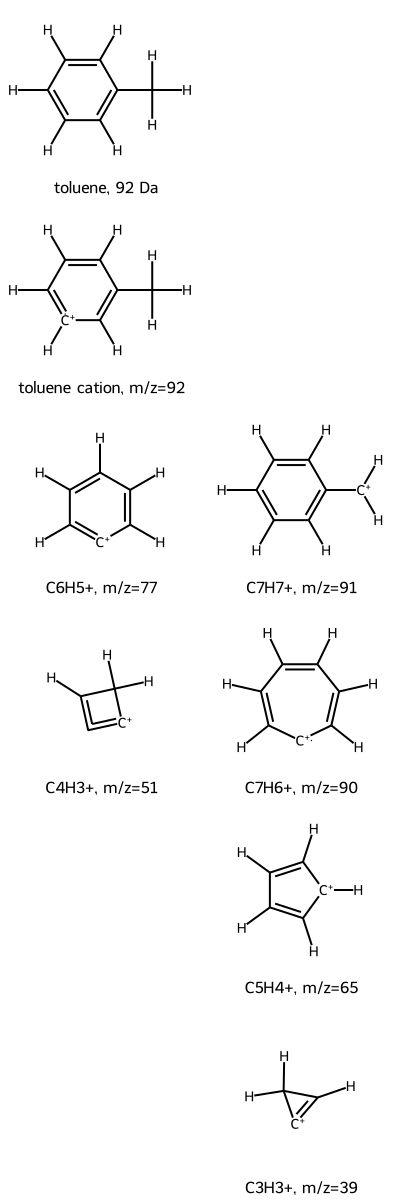

In [705]:
# Create mass spectrometry fragmentation tree
toluene = NonBinTree("Cc1ccccc1", "toluene")
toluene_cation = toluene.add_node("CC1=C[CH+]=CC=C1", "toluene cation")
C6H5_cation = toluene_cation.add_node("[C+]1=CC=CC=C1", "C6H5+")
C4H3_cation = C6H5_cation.add_node("[C+]1=C=CC1", "C4H3+")

C7H7_hex_ring_cation = toluene_cation.add_node("[CH2+]c1ccccc1", "C7H7+")
C7H7_hept_ring_cation = C7H7_hex_ring_cation.add_node("[C+]1C=CC=CC=C1", "C7H6+")
C5H5_cation = C7H7_hept_ring_cation.add_node("[CH+]1C=CC=C1", "C5H4+")
C3H3_cation = C5H5_cation.add_node("[C+]1=CC1", "C3H3+")

# toluene_ms_tree = mass_spec_frag_tree(toluene, None, addHs=True)

drawing, smiles_grid, labels_grid, mols_grid, masses_grid, charges_grid, mzs_grid = mass_spec_frag_tree(toluene, None, addHs=True, verbose=True)

drawing
# smiles_grid
# labels_grid
# mols_grid


In [706]:
masses_grid

[[92.062600256, 0.0],
 [92.06205167609, 0.0],
 [77.03857658009, 91.05422664409],
 [51.022926516089996, 90.04640161209],
 [0.0, 65.03857658009],
 [0.0, 39.022926516089996]]

In [707]:
charges_grid

[[0, 0], [1, 0], [1, 1], [1, 1], [0, 1], [0, 1]]

In [708]:
mzs_grid

[[0, 0],
 [92.06205167609, 0],
 [77.03857658009, 91.05422664409],
 [51.022926516089996, 90.04640161209],
 [0, 65.03857658009],
 [0, 39.022926516089996]]

Playing

[21:48:33] WARNING: not removing hydrogen atom without neighbors


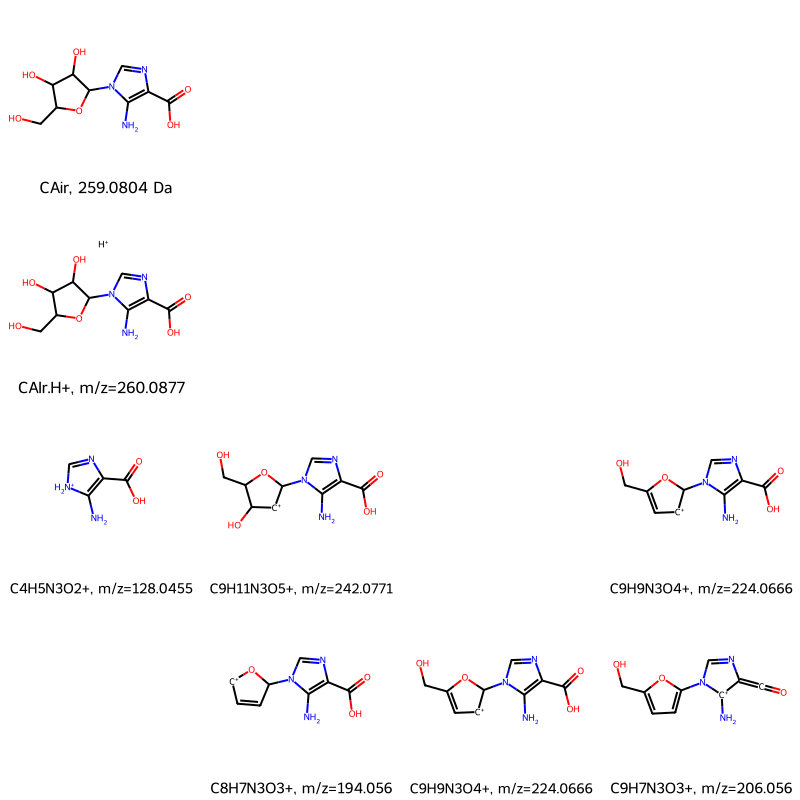

In [709]:
# Input SMILES
CAir_smiles = "Nc1c(C(=O)O)ncn1C2OC(CO)C(O)C2O"
CAIr_protonated_smiles = CAir_smiles + ".[H+]"
C9H11N3O5_smiles = "Nc1c(C(=O)O)ncn1C2[CH+]C(O)C(CO)O2"
C9H9N3O4_smiles = "Nc1c(C(=O)O)ncn1C2[CH+]C=C(CO)O2"
C9H7N3O3_smiles = "N[c+]1c(=C=O)ncn1c2ccc(CO)o2"
C8H7N3O3_smiles = "Nc1c(C(=O)O)ncn1C2C=C[CH+]O2"
C4H5N3O2_smiles = "NC1=C(C(=O)O)N=C[NH2+]1"

# Create mass spectrometry fragmentation hierarchy
CAir = NonBinTree(CAir_smiles, "CAir")
CAIr_protonated = CAir.add_node(CAIr_protonated_smiles, "CAIr.H+")
C4H5N3O2 = CAIr_protonated.add_node(C4H5N3O2_smiles, "C4H5N3O2+")
C9H11N3O5 = CAIr_protonated.add_node(C9H11N3O5_smiles, "C9H11N3O5+")
C8H7N3O3 = C9H11N3O5.add_node(C8H7N3O3_smiles, "C8H7N3O3+")
C9H9N3O4_ms4 = C9H11N3O5.add_node(C9H9N3O4_smiles, "C9H9N3O4+")
C9H9N3O4_ms3 = CAIr_protonated.add_node(C9H9N3O4_smiles, "C9H9N3O4+")
C9H7N3O3 = C9H9N3O4_ms3.add_node(C9H7N3O3_smiles, "C9H7N3O3+")

mass_spec_frag_tree(CAir, 4)

[21:48:33] WARNING: not removing hydrogen atom without neighbors


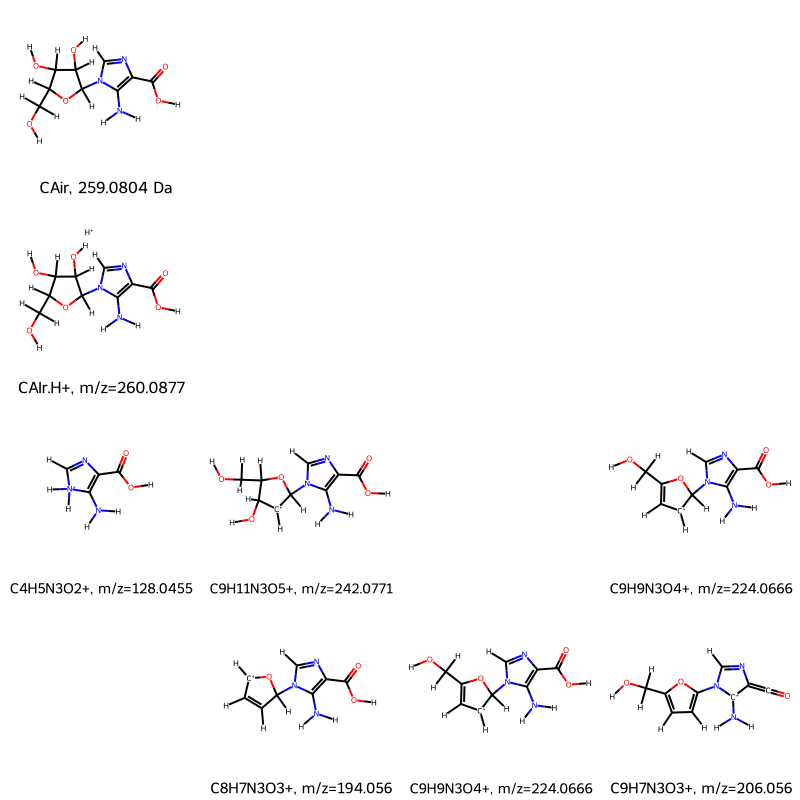

In [710]:
mass_spec_frag_tree(CAir, 4, addHs=True)

In [711]:
drawing, smiles_grid, labels_grid, mols_grid, masses_grid, charges_grid, mzs_grid = mass_spec_frag_tree(CAir, 4, verbose=True)

[21:48:33] WARNING: not removing hydrogen atom without neighbors


In [712]:
# drawing

In [713]:
smiles_grid

[['Nc1c(C(=O)O)ncn1C2OC(CO)C(O)C2O', '', '', ''],
 ['Nc1c(C(=O)O)ncn1C2OC(CO)C(O)C2O.[H+]', '', '', ''],
 ['NC1=C(C(=O)O)N=C[NH2+]1',
  'Nc1c(C(=O)O)ncn1C2[CH+]C(O)C(CO)O2',
  '',
  'Nc1c(C(=O)O)ncn1C2[CH+]C=C(CO)O2'],
 ['',
  'Nc1c(C(=O)O)ncn1C2C=C[CH+]O2',
  'Nc1c(C(=O)O)ncn1C2[CH+]C=C(CO)O2',
  'N[c+]1c(=C=O)ncn1c2ccc(CO)o2']]

In [714]:
labels_grid

[['CAir', '', '', ''],
 ['CAIr.H+', '', '', ''],
 ['C4H5N3O2+', 'C9H11N3O5+', '', 'C9H9N3O4+'],
 ['', 'C8H7N3O3+', 'C9H9N3O4+', 'C9H7N3O3+']]

In [715]:
mols_grid

[[<rdkit.Chem.rdchem.Mol at 0x16cd0fca0>,

In [716]:
masses_grid

[[259.080435136, 0.0, 0.0, 0.0],
 [260.08771158809003, 0.0, 0.0, 0.0],
 [128.04545285209, 242.07714690409, 0.0, 224.06658222009],
 [0.0, 194.05601753609, 224.06658222009, 206.05601753609]]

In [717]:
charges_grid

[[0, 0, 0, 0], [1, 0, 0, 0], [1, 1, 0, 1], [0, 1, 1, 1]]

In [718]:
mzs_grid

[[0, 0, 0, 0],
 [260.08771158809003, 0, 0, 0],
 [128.04545285209, 242.07714690409, 0, 224.06658222009],
 [0, 194.05601753609, 224.06658222009, 206.05601753609]]